In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
#Generates a random kernel of given dimensions and num_channels
def random_kernel(dimension,num_channels):
    dimension = dimension+(num_channels,)
    kernel = torch.randn(dimension)
    return kernel

#Generates a number of random kernels and return a array containing all of them 
def generate_kernels(num_filters,kernel_dimensions,num_channels = 3):
    kernels = []
    for i in range(num_filters):
        kernels.insert(i,random_kernel(kernel_dimensions,num_channels))
    return kernels

In [3]:
# List of activation Functions
def sigmoid(x):
    return (1/(1+torch.exp(-x)))

def tanh(x):
    return ((torch.exp(x)-torch.exp(-x))/(torch.exp(x)+torch.exp(-x)))

def ReLU(x):
    m,n = x.shape
    for i in range(m):
        for j in range(n):
            x[i,j] = max(0,x[i,j])
    return x

def PReLU(x,alpha):
    m,n = x.shape
    for i in range(m):
        for j in range(n):
            if(x[i,j]<0):
                x[i,j] = x[i,j]*alpha
    return x

#Softmax function on a vector
def softmax(x):
    x = torch.exp(x)
    sum = x.sum()
    return x/sum


In [4]:
def convolution(img, kernel, stride, padding, act_func):
    width, height, num_channels = img.shape
    kernel_width,kernel_height,kernel_length = kernel.shape
    # Pad the input image with 0s
    # New dimensions of image after padding
    new_width = width+2*padding
    new_height = height+2*padding
    # Change the image after padding
    new_img = torch.zeros(new_width,new_height,num_channels)
    new_img[padding:padding+width,padding:padding+height,:]=img
    img = new_img
    # Convoluted matrix dimensions
    conv_width = int((new_width-kernel_width)/stride) + 1
    conv_height = int((new_height-kernel_height)/stride) + 1
    conv_img = torch.zeros(conv_width,conv_height)
    #
    for i in range(conv_width):
        for j in range(conv_height):
            block = img[i*stride:i*stride+kernel_width,j*stride:j*stride+kernel_height,:]
            conv_img[i, j] += torch.sum(torch.mul(block,kernel))
    output_act_map = act_func(conv_img)
    return output_act_map

# Question 1

Input Image of iith


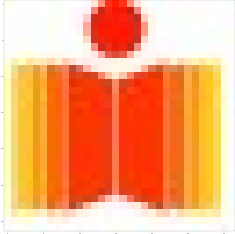

In [5]:
# Converting the image into array
img_array = mpimg.imread("iith_logo.jpg")/255
print("Input Image of iith")
plt.figure(figsize=(30, 30), dpi=10)
plt.imshow(img_array)
plt.show()

# Converting the image array into image tensor
img_tensor = torch.from_numpy(img_array)

Kernel we will use for convolution:


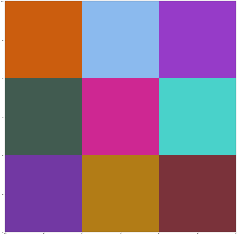

In [6]:
# Generating a random kernel with elements from normal distribution N(0,1)
num_channels = img_tensor.shape[2]
kernel = torch.rand(3, 3, num_channels)
print("Kernel we will use for convolution:")
plt.figure(figsize=(30, 30), dpi=10)
plt.imshow(kernel)
plt.show()

Convolved Image with above kernel:


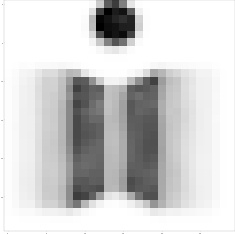

In [7]:
# Convolving the input image with the random kernel
conv_img = convolution(img_tensor, kernel, 1, 0, sigmoid)

# Showing the obtained convoluted tensor in image form
print("Convolved Image with above kernel:")
plt.figure(figsize=(30, 30), dpi=10)
plt.imshow(conv_img,cmap='gray')
plt.show()

# Question 2

In [8]:
#List of pooling functions
def max_pooling(x):
    return torch.max(x)

def average_pooling(x):
    return torch.mean(x)

#Pooling function for act_map
def pooling(act_map,kernel_dimensions,stride=2,pooling_function=max_pooling):
    width,height = act_map.shape
    kernel_width,kernel_height= kernel_dimensions
    new_width = int((width-kernel_width)/stride+1)
    new_height = int((height-kernel_height)/stride+1)
    pooled_map = torch.zeros(new_width,new_height)
    for i in range(new_width):
        for j in range(new_height):
            pooling_block = act_map[i*stride:i*stride+kernel_width,j*stride:j*stride+kernel_height]
            pooled_map[i,j] = pooling_function(pooling_block)
    return pooled_map

Pooled image:


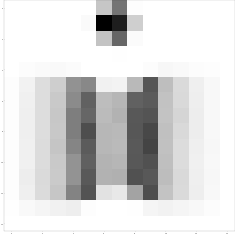

In [9]:
pooled_img = pooling(conv_img, (2, 2))
print("Pooled image:")
plt.figure(figsize=(30, 30), dpi=10)
plt.imshow(pooled_img,cmap='gray')
plt.show()

# Question 3

In [10]:
def convolution_layer(img,kernels,stride=1,padding=0,act_func=sigmoid):
    num_channels = img.shape[-1]
    kernel_dimensions = kernels[0].shape
    num_filters = len(kernels)
    new_width = int((img.shape[0]-kernel_dimensions[0]+2*padding)/stride+1)
    new_height = int((img.shape[1]-kernel_dimensions[1]+2*padding)/stride+1)
    convoluted_volume = torch.zeros(new_width,new_height,num_filters)
    for i in range(num_filters):
        convoluted_volume[:,:,i] = convolution(img, kernels[i], stride, padding, act_func)
    act_volume = act_func(convoluted_volume)
    return act_volume

Convoluted activation : 1


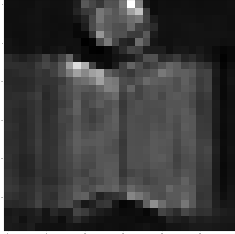

Convoluted activation : 2


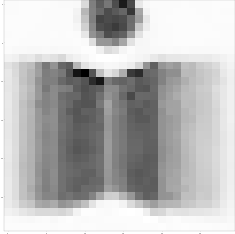

Convoluted activation : 3


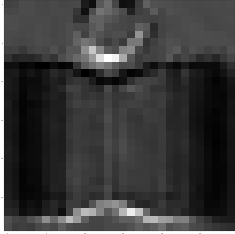

Convoluted activation : 4


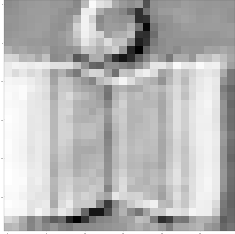

Convoluted activation : 5


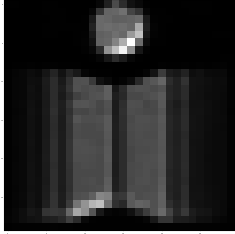

In [11]:
# Generating 5 random kernels of size (3,3)  
kernels = generate_kernels(5,(3,3))
# Activation Volume containing all activation maps from convolving that image with those kernels
act_map = convolution_layer(img_tensor,kernels)

# Showing the obtained convoluted tensor in image form
for i in range(5):
    print("Convoluted activation :",i+1)
    plt.figure(figsize=(30, 30), dpi=10)
    plt.imshow(act_map[:,:,i],cmap="gray")
    plt.show()

# Question 4

In [12]:
def pooling_layer(act_map,kernel_dimensions,stride=2,pooling_function=max_pooling,global_average_pooling=False):
    width,height,num_channels = act_map.shape
    kernel_width,kernel_height= kernel_dimensions
    if(global_average_pooling):
        pooled_map = torch.zeros(num_channels)
        for i in range(num_channels):
            pooled_map[i]=torch.mean(act_map[:,:,i])
        return pooled_map
    new_width = int((width-kernel_width)/stride+1)
    new_height = int((height-kernel_height)/stride+1)
    pooled_map = torch.zeros(new_width,new_height,num_channels)
    for i in range(num_channels):
        pooled_map[:,:,i] = pooling(act_map[:,:,i],kernel_dimensions,stride,pooling_function)
    return pooled_map

Pooled activation : 1


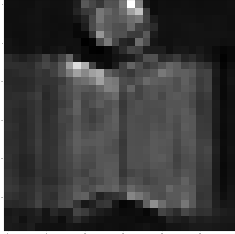

Pooled activation : 2


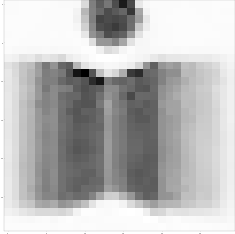

Pooled activation : 3


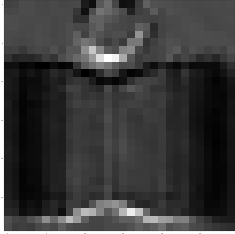

Pooled activation : 4


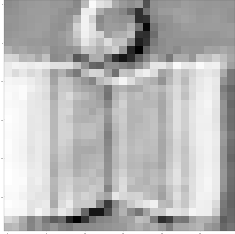

Pooled activation : 5


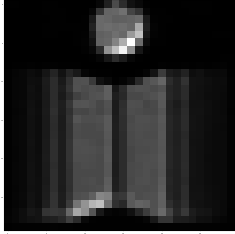

In [13]:
# Pooling a activation volume and generating output
input_map = act_map
pooled_img = pooling_layer(input_map, (3, 3), 3)
# Showing the obtained convoluted tensor in image form
for i in range(5):
    print("Pooled activation :",i+1)
    plt.figure(figsize=(30, 30), dpi=10)
    plt.imshow(act_map[:,:,i],cmap="gray")
    plt.show()

# Question 5

In [14]:
def flatten(act_map,output_size,weight_matrix=None):
    width,height,num_channels = act_map.shape
    flattened_map = torch.zeros(0)
    for c in range(num_channels):
        for h in range(height):
            flattened_map = torch.cat((flattened_map,act_map[:,h,c]))
    if (torch.numel(flattened_map)==output_size):
        return flattened_map
    else:
        if(weight_matrix!=None):
            output = weight_matrix@flattened_map
            return output
        weight_matrix = random_kernel((output_size,),torch.numel(flattened_map))
        output = weight_matrix@flattened_map
        return output

In [15]:
#Flattening the pooled activation volume to size 10
input = flatten(pooled_img,20)
print(input)

tensor([  5.6175, -11.1636,  25.4305, -22.5783,  10.0250, -18.0236,  -6.2845,
        -10.8821,   2.0362,  -5.9156, -17.7576,   8.3738,   9.9289,  10.5151,
         21.5324, -21.7781,   9.5121,  -0.3371,  23.9767,  14.3557])


# Question 6

In [16]:
def mlp(input,num_hidden,hidden_size,output_size,act_func=sigmoid,weight_matrices=None):
    if(weight_matrices!=None):
        for i in range(num_hidden):
            input = act_func(weight_matrices[i]@input)
        output = act_func(weight_matrices[-1]@input)
    else:
        for i in range(num_hidden):
            weight_matrix = torch.rand(hidden_size[i],torch.numel(input))
            input = act_func(weight_matrix@input)
        weight_matrix = torch.rand(output_size,torch.numel(input))
        output = act_func(weight_matrix@input)
    return output,softmax(output)

In [17]:
output,output_softmax = mlp(input,3,(10,5,10),5)
print("The last layer output in mlp is: ",output)
print("The mlp output after softmax is :",output_softmax)

The last layer output in mlp is:  tensor([0.9942, 0.9927, 0.9506, 0.9807, 0.9959])
The mlp output after softmax is : tensor([0.2023, 0.2020, 0.1936, 0.1995, 0.2026])


# Question 7

In [18]:
class CNN:
    
    def __init__(self):

        self.kernels1 = generate_kernels(16,(3,3),3)
        self.kernels2 = generate_kernels(8,(3,3),16)

        self.weight_matrices = []

        w = random_kernel((8,),8)
        self.weight_matrices.append(w)
        w = random_kernel((10,),8)
        self.weight_matrices.append(w)

        

    def feed_forward(self,input):

        # Convolution layer with 16 kernels of size 3 × 3 spatial dimensions and sigmoid activation.
        first_conv_output = convolution_layer(input,self.kernels1)

        # Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.
        first_pool_output = pooling_layer(first_conv_output,(2,2))

        # Convolution layer with 8 kernels of spatial size 3 × 3 and sigmoid activation.
        second_conv_output = convolution_layer(first_pool_output,self.kernels2)

        # Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.
        second_pool_output = pooling_layer(second_conv_output,(2,2))

        # A Global Average Pooling (GAP) layer.
        gap_output = pooling_layer(second_pool_output,(1,1),global_average_pooling=True)
    
        # An MLP with one hidden layer
        output_vec,output_vec_softmax = mlp(gap_output,1,(8,),10,weight_matrices=self.weight_matrices)

        return output_vec_softmax, gap_output

# Question 8

In [19]:
#Creating a CNN object and Passing the iith-logo image in feed forward 
cnn_object = CNN()
output_softmax,gap_output = cnn_object.feed_forward(img_tensor)
print("The vector obtained after global average pooling is :",gap_output)
print("The output softmax vector of mlp is :",output_softmax)

The vector obtained after global average pooling is : tensor([0.5000, 0.5017, 0.7309, 0.5610, 0.5747, 0.6348, 0.5000, 0.7309])
The output softmax vector of mlp is : tensor([0.0784, 0.0621, 0.1536, 0.1298, 0.0815, 0.0704, 0.1619, 0.1003, 0.1002,
        0.0618])


Since the CNN network is not trained the images won't show any discriminability
Even a iith-logo image could correspond to irrelevant object in CIFAR dataset 